<h1 style="text-align: center; ">Проект №1</h1>
<p style="text-align: center; ">Выполнили: Ануров Никита, Алешин Михаил, Бердышев Роман, Сулейманов Ильяс</p>

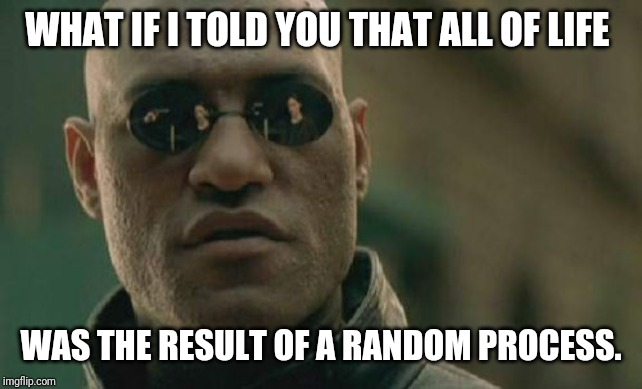

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_rows', 250)

In [3]:
from dataclasses import dataclass
from typing import Optional, NoReturn, Any, Union

import numpy as np
from sklearn.linear_model import LinearRegression

<h2 style="text-align: center; ">Часть 1</h2>

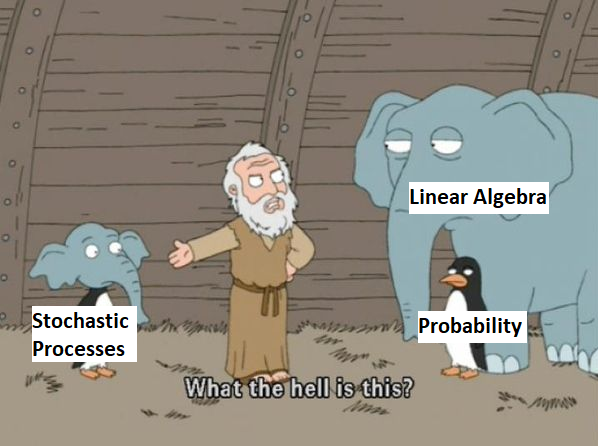

# Функции для построения CIR процесса

CIR модель задается формулой:
$$\sigma_t=\sigma_{t-1}+a\left(b-\sigma_{t-1}\right)+c \sqrt{\sigma_{t-1}} \Delta W_t$$

$$d \sigma_t=a\left(b-\sigma_t\right) d t+c \sqrt{\sigma_t} d W_t$$

Используя метод Эйлера-Маруямы аппроксимируем СДУ:

$$\Delta \sigma_t=a\left(b-\sigma_t\right) \Delta t+c \sqrt{\sigma_t} \epsilon_t$$

Примем $ \Delta t=1 $ и поделим на $\sigma_{-} t$

$$\frac{\Delta \sigma_t}{\sqrt{\sigma_t}}=\frac{a b}{\sqrt{\sigma_t}}-a \sqrt{\sigma_t}+c \varepsilon_t$$

Где $\varepsilon$ - независимые одинаково распределённые случайные величины

Пользуясь заменой переменных:

$$
\left\{\begin{array}{l}
y \equiv \frac{\Delta \sigma_t}{\sqrt{\sigma_t}} \\
x_1 \equiv \frac{1}{\sqrt{\sigma_t}} \\
x_2 \equiv \sqrt{\sigma_t}
\end{array}\right.
$$

Тогда финальное выражение можно записать в виде:

$$
y=\tilde{a} x_1+\tilde{b} x_2+c \varepsilon_t
$$

Параметры оцениваются при помощи линейной регрессии

Первая функция принимает на вход список приращений Винеровского процесса, CIR параметры в видел словаря и строит сам процесс    
Вторая функция оценивает параметры  
Третья функция строит необходимое количество симуляций

In [4]:
def get_process(dW, CIR_params):
    T = len(dW)
    sigma_t = [CIR_params['b']]
    for t in range(1, T):
        dsigma_t = (
            CIR_params['a'] * (CIR_params['b'] - sigma_t[t - 1])
            + CIR_params['c'] * np.sqrt(sigma_t[t - 1]) * dW[t]
        )
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)

def estimate_CIR_params(sigma_t: np.ndarray):
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = sigma_t[-1]
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    
    CIR_params = dict()
    CIR_params['a'] = a
    CIR_params['b'] = b
    CIR_params['c'] = c
    return CIR_params

def get_n_procs(T, CIR_params, n_procs):
    dWs = []
    for i in range(n_procs):
        dW_i = np.random.normal(0.0, 1.0, T)
        dWs.append(dW_i)
    dWs = np.asarray(dWs).T
    
    CIR_procs = []
    for i in range(n_procs):
        dW_i = dWs[:, i]
        CIR_procs.append(get_process(dW_i, CIR_params))
    return dWs, np.asarray(CIR_procs).T

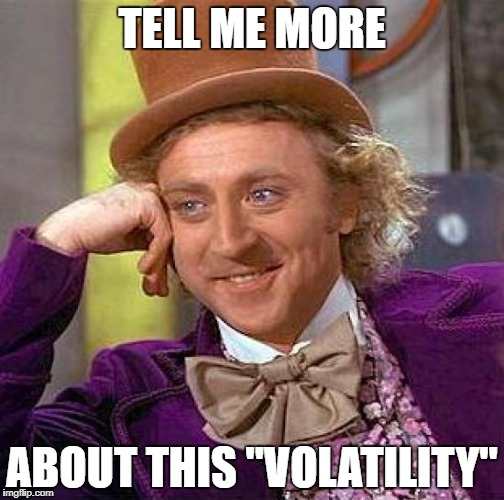

# Функции для построения FX процесса

Для построения симуляции FX-процесса использовалась формула для обменного курса с лекции:  

$$\frac{dX_t}{X_T} = a(b - lnX_t)dt + cdW_t$$

где $a$ - скорость возвращения к среднему $b$, $c$ - волатильность. Это все параметры модели.  $dW_s$ - приращения Винеровского процесса, 
$X_t$ - обменный курс.  
Решая диффур получим(и принимая $\Delta t = 1$):

$$dlnX_t = a(b - lnX_{t-1}) + c\Delta W_t$$

Для оценки параметров использовалась линейная регрессия на исторических данных. С помощью метода Эйлера-Маруямы было получено приближенное решение дифференциального уравнения и составлено уравнения для линейной регресии вида: 

$$y = kx + v + c\varepsilon_t$$

где $k = -a$, $v = ab$

Логика и смысл функций аналогичны CIR процессу

In [5]:
def get_FX_process(dW, FX_params):
    T = len(dW)
    X_t = [FX_params['b']]
    for t in range(1, T):
        dX_t = (
            FX_params['a'] * (FX_params['b'] - X_t[t - 1])
            + FX_params['c'] * dW[t]
        )
        X_t.append(X_t[t - 1] + dX_t)
    return np.asarray(X_t)

def estimate_FX_params(X_t: np.ndarray):
    y = np.diff(X_t)
    x = X_t[:-1]
    X = np.concatenate([np.ones(x.shape).reshape(-1, 1), x.reshape(-1, 1)], axis=1)
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = X_t[-1]
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    
    FX_params = dict()
    FX_params['a'] = a
    FX_params['b'] = b
    FX_params['c'] = c
    return FX_params

def get_n_procs_FX(T, FX_params, n_procs):
    dWs = []
    for i in range(n_procs):
        dW_i = np.random.normal(0.0, 1.0, T)
        dWs.append(dW_i)
    dWs = np.asarray(dWs).T
    
    FX_procs = []
    for i in range(n_procs):
        dW_i = dWs[:, i]
        FX_procs.append(get_FX_process(dW_i, FX_params))
    return dWs, np.asarray(FX_procs).T

# Функция с симуляциями скоррелированных риск-факторов

Для того, чтобы получить скоррелированные риск-факторы было применено разложение Холецкого. Скоррелированность риск-факторов, задаваемых СДУ, обеспечивается скоррелированностью стохастических компонент. Поэтому мы составили матрицу корреляций для приращений Винеровского процесса и для нее построили разложение Холецкого. Далее домножили изначальные приращения Винеровского процесса для каждого риск-фактора на это разложение и получили скоррелированные между собой риск-фаткоры. 

Функция принимает на вход количество точек в симуляции, дату старта, дату окончания и количество симуляций. На выходе получаются три скоррелированные риск-фактора, которые используются во второй части задания

In [6]:
from sklearn.preprocessing import StandardScaler
from datetime import date, datetime

def simulate_CIR_process(data, start_date, end_date, n_procs):
    start_point = np.nonzero(data.index == start_date)[0][0]
    T_hat = pd.date_range(start_date, end_date).shape[0]
    init_proc = data.values
    
    CIR_params_hat = estimate_CIR_params(init_proc[:start_point])
    dWs, CIR_procs = get_n_procs(T, CIR_params_hat, n_procs)
    return dWs.T, CIR_procs.T


def simulate_FX_process(data, start_date, end_date, n_procs):
    start_point = np.nonzero(data.index == start_date)[0][0]
    T_hat = pd.date_range(start_date, end_date).shape[0]
    init_proc = data.values
    
    FX_params_hat = estimate_FX_params(init_proc[:start_point])
    dWs, FX_procs = get_n_procs_FX(T, FX_params_hat, n_procs)
    return dWs.T, FX_procs.T



def create_process(T, start_date, end_date, n_procs):
    dWs_rub, CIR_procs_rub = simulate_CIR_process(df_rub, start_date, end_date, n_procs)
    dWs_usd, CIR_procs_usd = simulate_CIR_process(df_usd, start_date, end_date, n_procs)
    dWs_fx, FX_procs = simulate_FX_process(df_usd_rub, start_date, end_date, n_procs)
    CIR_procs_rub_tr = []
    CIR_procs_usd_tr = []
    FX_procs_tr = []
    for idx in range(FX_procs.shape[0]):
        corr_matrix = pd.DataFrame(np.stack((dWs_rub[idx], dWs_usd[idx], dWs_fx[idx]))).T.corr()

        sc = StandardScaler()

        tmptmp = sc.fit_transform(np.stack((CIR_procs_rub[idx], CIR_procs_usd[idx], FX_procs[idx])).T)

        tmp = tmptmp.dot(np.linalg.cholesky(corr_matrix))

        tmp = sc.inverse_transform(tmp).T
        CIR_procs_rub_tr.append(tmp[0])
        CIR_procs_usd_tr.append(tmp[1])
        FX_procs_tr.append(tmp[2])
    return np.stack(CIR_procs_rub_tr), np.stack(CIR_procs_usd_tr), np.stack(FX_procs_tr)

# Задаем начало и конец
Выбранный масштаб 1 день

In [7]:
start_date = '2021-09-01'
end_date = '2021-10-12'
T = pd.date_range(start_date, end_date).shape[0]

# Мгновенная процентная ставка для России

In [8]:
#загружаем данные
df = pd.read_csv('./russian_key_rate.txt', sep='\t').iloc[1:, :-1]
df['Release Date'] = df.apply(lambda row: pd.to_datetime(row[0].split(' (')[0]), axis=1)
df = df[['Release Date', 'Actual']].drop_duplicates()
df = df.set_index('Release Date')['Actual'].resample('1D').sum().replace(0, np.nan)\
            .fillna(method='ffill', axis=0).loc['2008-01-01':end_date]
df_rub = df.apply(lambda row: float(row[:-1]))

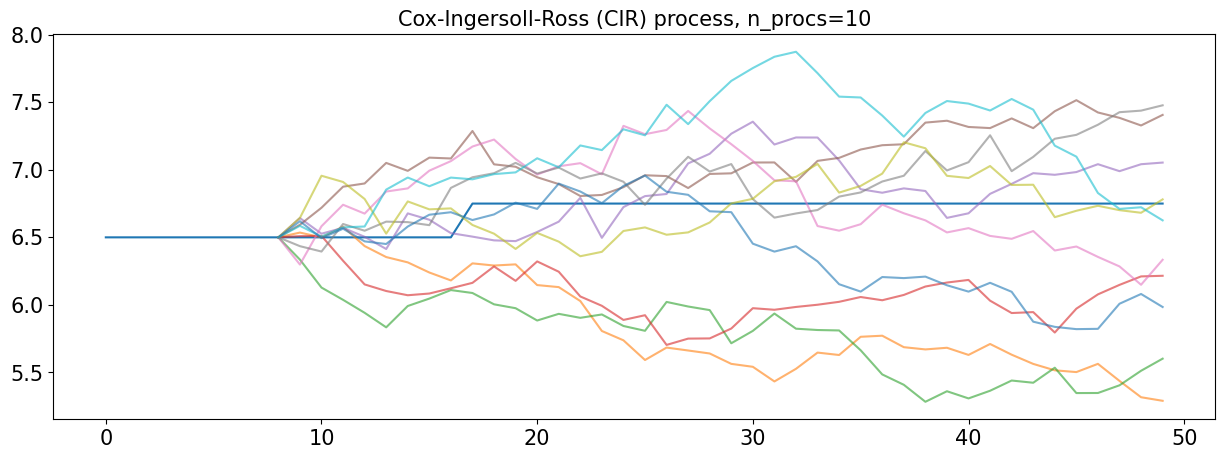

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

start_point = np.nonzero(df_rub.index == start_date)[0][0]
init_proc = df_rub.values
n_procs = 10

dWs, CIR_procs = simulate_CIR_process(df_rub, start_date, end_date, n_procs)
dWs, CIR_procs = dWs.T, CIR_procs.T

plot_range = 50
plt.figure(figsize=(15, 5))
title = f"Cox-Ingersoll-Ross (CIR) process, {n_procs=}"
plt.plot(list(range(plot_range)), init_proc[start_point+T-plot_range:start_point+T])
plt.plot(list(range(plot_range-T, plot_range)), CIR_procs, alpha=0.6)
plt.title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

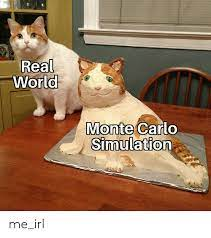

# Мгновенная процентная ставка для США

In [10]:
#загружаем данные
df = pd.read_csv('./us_key_rate.txt', sep='\t').iloc[1:, :-1]
df['Release Date'] = df.apply(lambda row: pd.to_datetime(row[0].split(' (')[0]), axis=1)
df = df[['Release Date', 'Actual']].drop_duplicates()
df = df.set_index('Release Date')['Actual'].resample('1D').sum().replace(0, np.nan)\
            .fillna(method='ffill', axis=0).loc['2008-01-01':end_date]
df_usd = df.apply(lambda row: float(row[:-1]))

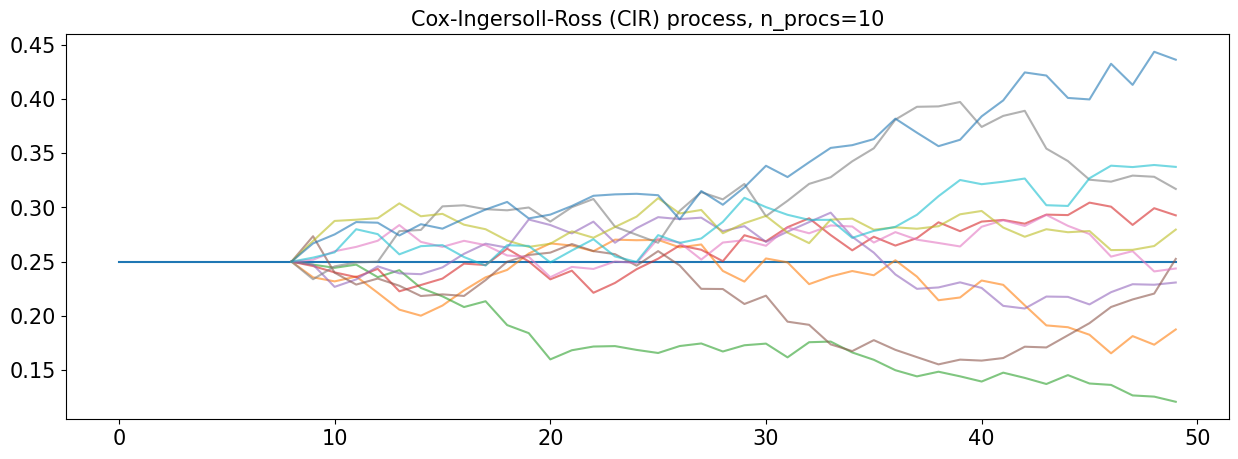

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

start_point = np.nonzero(df_usd.index == start_date)[0][0]
init_proc = df_usd.values
n_procs = 10

dWs, CIR_procs = simulate_CIR_process(df_usd, start_date, end_date, n_procs)
dWs, CIR_procs = dWs.T, CIR_procs.T

plot_range = 50
plt.figure(figsize=(15, 5))
title = f"Cox-Ingersoll-Ross (CIR) process, {n_procs=}"
plt.plot(list(range(plot_range)), init_proc[start_point+T-plot_range:start_point+T])
plt.plot(list(range(plot_range-T, plot_range)), CIR_procs, alpha=0.6)
plt.title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Обменный курс рубль доллар

In [12]:
#загружаем данные
df = pd.read_csv('usd_rub_course.csv')[['Date', 'Adj Close']]
df['Date'] = pd.to_datetime(df['Date'])
df_usd_rub = df.set_index('Date')['Adj Close'].resample('1D').sum().replace(0, np.nan)\
            .fillna(method='ffill', axis=0).loc['2008-01-01':end_date]

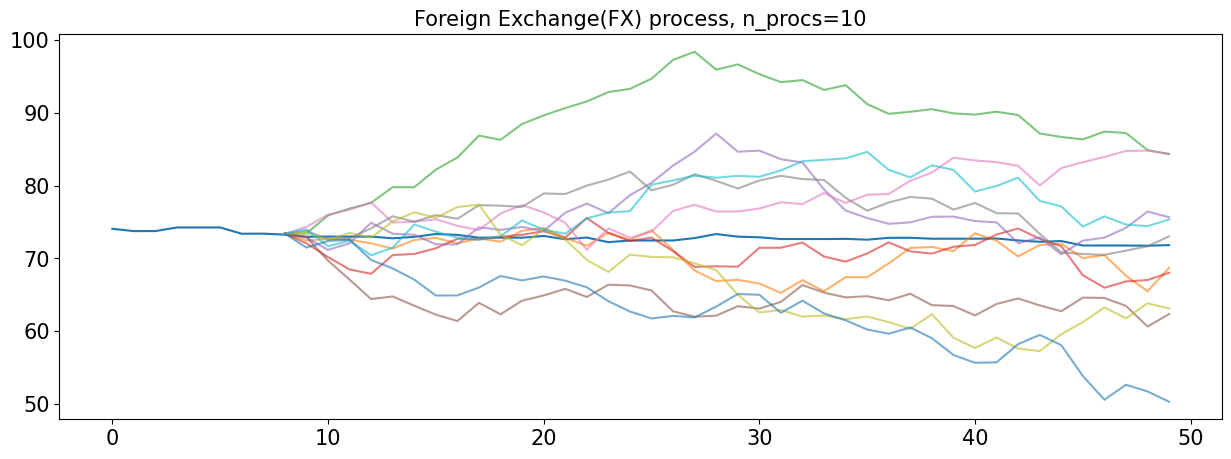

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

start_point = np.nonzero(df_usd_rub.index == start_date)[0][0]
init_proc = df_usd_rub.values
n_procs = 10

dWs, FX_procs = simulate_FX_process(df_usd_rub, start_date, end_date, n_procs)
dWs, FX_procs = dWs.T, FX_procs.T

plot_range = 50
plt.figure(figsize=(15, 5))
title = f"Foreign Exchange(FX) process, {n_procs=}"
plt.plot(list(range(plot_range)), init_proc[start_point+T-plot_range:start_point+T])
plt.plot(list(range(plot_range-T, plot_range)), FX_procs, alpha=0.6)
plt.title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

<h2 style="text-align: center; ">Часть 2</h2>

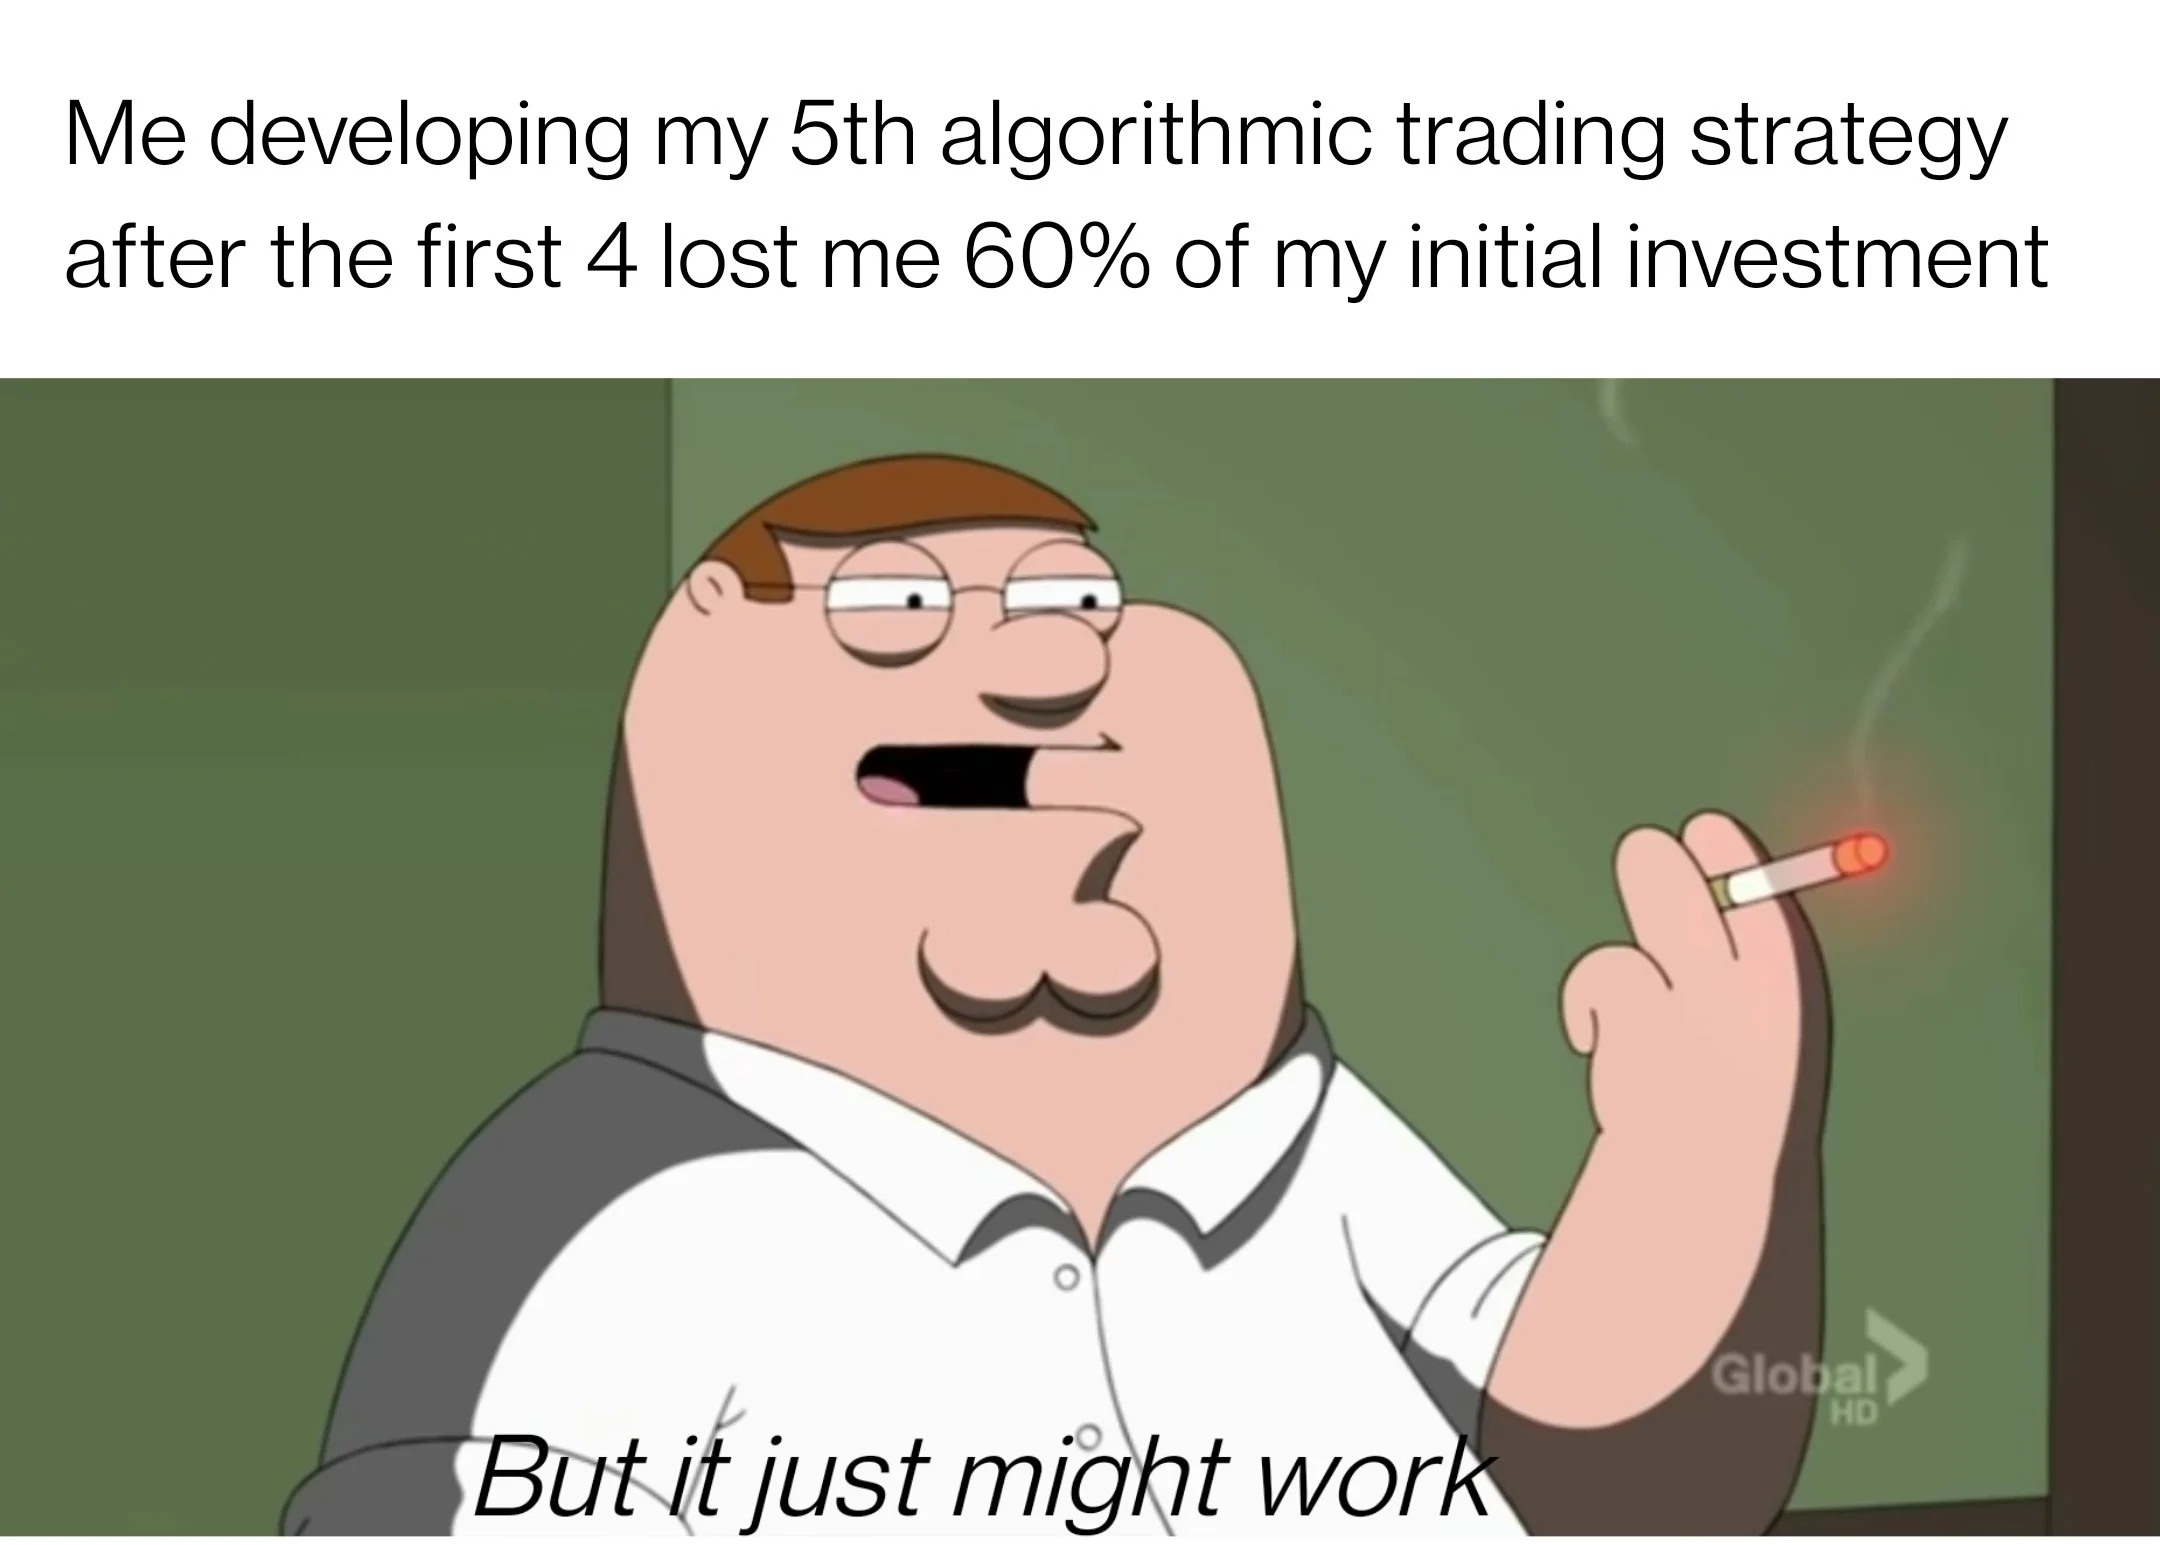

# Функция для расчета стоимости Range Accrual  

 - Фукнция принимает keyword-аргументы, если в нее передавать аргументы позиционно, то она может отработать __некорректно или выдать ошибку__
 - Обязательными аргументами функции являются _дата старта_(__date_start__) и _дата окончания_(__date_end__), аргументы _верхней границы_(__upper_lim__), _нижней границы_(__lower_lim__) и _номинала сделки_(__fin_tool__) не являются обязательными и по умолчанию равны $+\infty$, 0 и 1000 соответственно.  Даты перадаются в формате "ГГГГ-ММ-ДД"  
 - данные для симуляций загружены выше(см. датафрейм по России/США/обменному курсу) они содержат исторические данные с 2008 года с временным шагом равным 1 дню  
 - сам $RA$ высчитывается по формуле:  
$$ RA = \frac{1}{S}\sum^{S}Payoff  $$
$$Payoff = nominal * \frac{1}{N} * \sum^{N}I[L_l < value < L_u],$$
где $S$ - кол-во симуляций, $N$ - кол-во точек в симуляции, $nominal$ - номинал сделки, $L_l$ и $L_u$ верхние и нижние границы соответственно    


 - кол-во точек симуляций равно кол-ву точек между датой старта и датой окончания контракта  
 - шаг симуляции берем равным 1 дню, тк мы считаем, что брать шаг с меньшей гранулярностью не имеет смысла, тк частота изменения ставки раз в несколько месяцев, и шаг в 1 день нас удовлетворяет
 - чем больше траекторий мы возьмем, тем выше точность у нас будет, но также стоит учитывать время расчета, поэтому кол-во траекторий берем равным 10000

In [14]:
def range_accrual_price(date_start, date_end, upper_lim = np.inf , lower_lim = 0, fin_tool = 1000):
    date1 = datetime.strptime(date_start, '%Y-%m-%d').date()
    date2 = datetime.strptime(date_end, '%Y-%m-%d').date()
    T = abs(date1-date2).days
    
    data_tr, _, _ = create_process(T, date_start, date_end, 10000)
    payoffs = []
    for data in data_tr:
        payoffs.append(np.mean(((data > lower_lim)&(data < upper_lim)).astype(int)))
    RA = np.mean(payoffs) * fin_tool
    print(f'Стоимость  RA = {RA:.2f}')
    return payoffs , RA

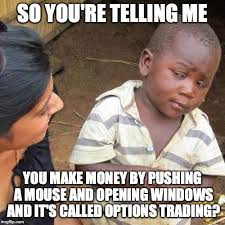

In [15]:
payoffs, RA = range_accrual_price('2021-08-21', '2021-10-12', 9, 6, 1000)

Стоимость  RA = 855.46


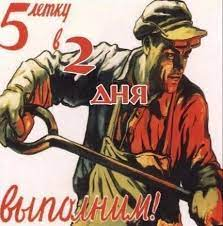